In [1]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import scipy.stats as st
import os

from scipy.interpolate import interp1d
from netCDF4 import Dataset

from fair.ancil import cmip6_solar, cmip6_volcanic, natural
from fair.forward import fair_scm
from fair.constants import molwt
from fair.tools.magicc import scen_open
from fair.RCPs import rcp85, rcp26
from fair.ancil.cmip5_annex2_forcing import Forcing

In [2]:
%matplotlib inline
    
pl.rcParams['figure.figsize'] = (16, 9)
pl.rcParams['font.size'] = 18
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.top'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.direction'] = 'in'
pl.rcParams['ytick.direction'] = 'in'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True

In [3]:
emissions_ssp585 = scen_open('data_in/SSP585_1765.SCEN')
# strange unit for N2O - get back into what FAIR wants
emissions_ssp585[:,4] = emissions_ssp585[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp126 = scen_open('data_in/SSP126_1765.SCEN')
emissions_ssp126[:,4] = emissions_ssp126[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp245 = scen_open('data_in/SSP245_1765.SCEN')
emissions_ssp245[:,4] = emissions_ssp245[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp119 = scen_open('data_in/SSP119_1765.SCEN')
emissions_ssp119[:,4] = emissions_ssp119[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp370 = scen_open('data_in/SSP370_1765.SCEN')
emissions_ssp370[:,4] = emissions_ssp370[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp370_lowNTCF = scen_open('data_in/SSP370-LOWNTCF_1765.SCEN')
emissions_ssp370_lowNTCF[:,4] = emissions_ssp370_lowNTCF[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp434 = scen_open('data_in/SSP434_1765.SCEN')
emissions_ssp434[:,4] = emissions_ssp434[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp460 = scen_open('data_in/SSP460_1765.SCEN')
emissions_ssp460[:,4] = emissions_ssp460[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ssp534_over = scen_open('data_in/SSP534-OVER_1765.SCEN')
emissions_ssp534_over[:,4] = emissions_ssp534_over[:,4]*0.001*molwt.N2/molwt.N2O
emissions_ndc = scen_open('data_in/NDC_2020.SCEN')

array([[1.        , 0.76682188],
       [0.76682188, 1.        ]])

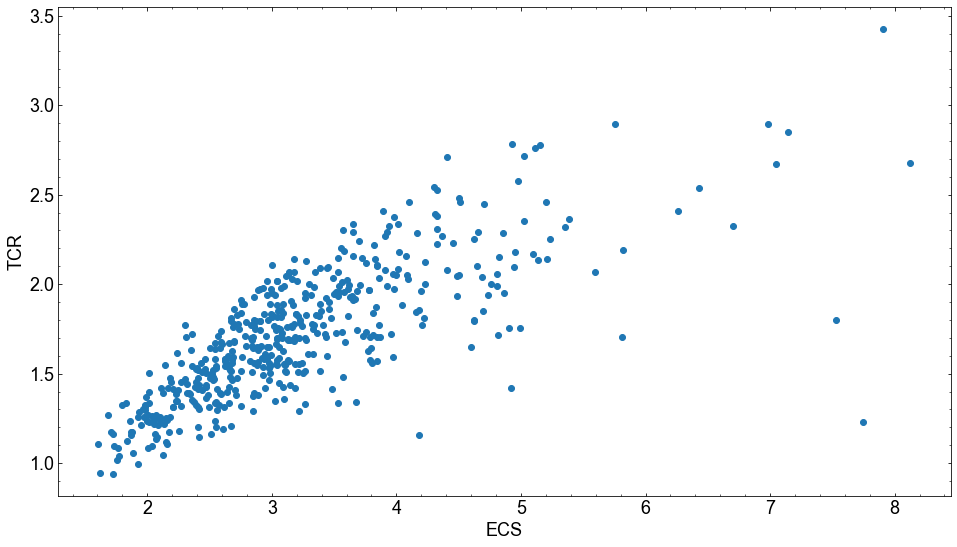

In [4]:
# draw distributions of ECS and TCR: 5-95% range 1.0 to 2.2 for TCR normal, 2-5 for ECS lognormal
samples = 500
seed    = 36572

feedback = -1.34 * st.truncnorm.rvs(-2.5, np.inf, loc=1, scale=0.28, size=samples, random_state=14)
f2x = 4.01
ecs = -4.01/feedback
rwf = st.norm.rvs(size=samples, loc=np.maximum(0.75*np.exp(-0.075*ecs**1.2), 0.2), scale=0.07*np.exp(-0.03*ecs**0.9), random_state=11)
tcr = ecs*rwf
tcrecs = np.stack((tcr,ecs)).T

pl.scatter(ecs, tcr)
pl.xlabel('ECS')
pl.ylabel('TCR')
np.corrcoef((ecs,tcr))

[1.9794893  2.37040157 3.03857646 3.97068852 4.99654705]


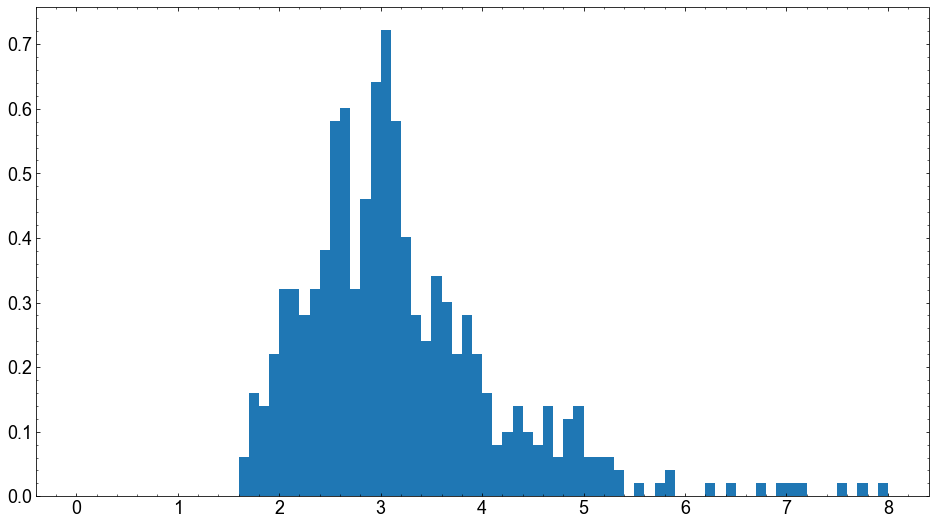

In [5]:
pl.hist(ecs, bins=np.arange(0,8.1,0.1), density=True);
print(np.percentile(ecs, (5,17,50,83,95)))

[1.17542774 1.35331543 1.69595966 2.05073848 2.36481743]


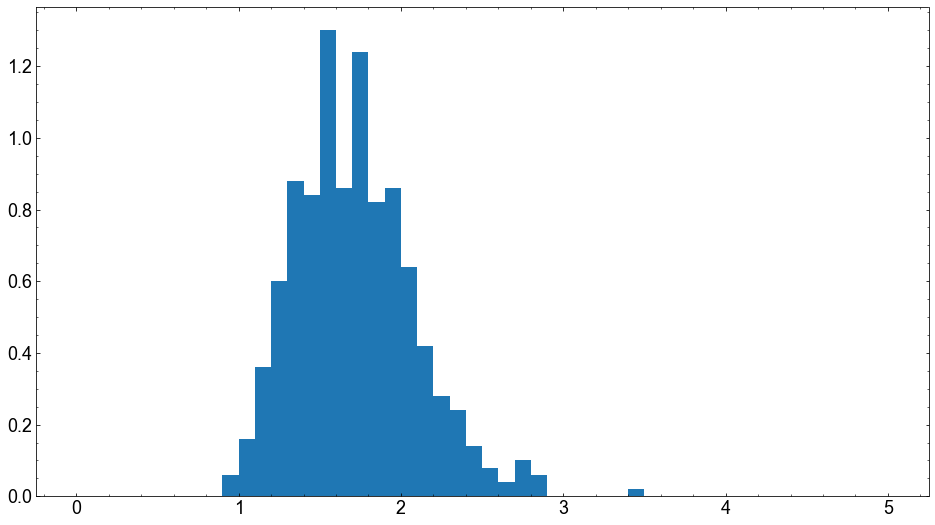

In [6]:
pl.hist(tcr, bins=np.arange(0,5.1,0.1), density=True);
print(np.percentile(tcr, (5,17,50,83,95)))

In [7]:
# fractional uncertainties - based on the FAIR code
seed    = 36572 
zscore = st.norm.ppf(0.95)

unc_ranges = np.array([0.17,      # CO2
                   0.17,      # CH4: updated value from etminan 2016
                   0.10,      # N2O
                   0.20,      # other WMGHS
                   0.50,      # tropospheric O3
                   1.00,      # stratospheric O3
                   5./7.,     # stratospheric WV from CH4
                   0.00,      # contrails (lognormal)
                   0.7/1.1,   # aerosols - NEW!
                   0.00,      # black carbon on snow (lognormal)
                   2./3.,     # land use change
                   3.5/18.5,  # volcanic
                   1.00])/(zscore) # solar

scale = st.norm.rvs(size=(samples,13), loc=np.ones((samples,13)), scale=np.ones((samples, 13)) * unc_ranges[None,:], random_state=seed)
scale[:,9] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)

# truncated normal distribution for contrails
scale[:,7] = st.truncnorm.rvs(-1.68, 5, loc=1, scale=1/st.norm.ppf(0.95), size=samples, random_state=seed+2)

# aerosols are asymmetric Gaussian
scale[scale[:,8]<1,8] = 0.6/0.7*(scale[scale[:,8]<1,8]-1) + 1

# as is solar
scale[:,12] = scale[:,12] - 1.0
scale[scale[:,12]>0,12] = 2*(scale[scale[:,12]>0,12])

# inlcude CO2 and CH4 rapid adjustments
scale[:,0] = scale[:,0] * 1.05
scale[:,1] = scale[:,1] * 0.86

# scale aerosols by 0.62 to get 2014 = -1.1
scale[:,8] = scale[:,8] * 0.62

In [8]:
# carbon cycle uncertainties based on fair 1.3 defaults and uncertainty range from Millar
r0       = st.norm.rvs(loc=32.4, scale=32.4*0.13, size=samples, random_state=37631)
rc       = st.norm.rvs(loc=0.019, scale=0.019*0.13, size=samples, random_state=36292836)
rt       = st.norm.rvs(loc=4.165, scale=4.165*0.13, size=samples, random_state=827692)

In [9]:
vol = cmip6_volcanic.Forcing.volcanic
sol = cmip6_solar.Forcing.solar
nat = natural.Emissions.emissions

In [10]:
nt = 336
Tndc = np.zeros((336, samples))
Cndc = np.zeros((336, samples))
Fndc = np.zeros((336, samples))
for i in range(samples):
    C,F,Tndc[:,i] = fair_scm(
        emissions=emissions_ndc[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cndc[:,i] = C[:,0]
    Tndc[:,i] = Tndc[:,i] - np.mean(Tndc[85:136,i])
    Fndc[:,i] = np.sum(F, axis=1)

/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [11]:
conc_columns = [
    'CO2 (ppm)',
    'CH4 (ppb)',
    'N2O (ppb)',
    'CF4',
    'C2F6',
    'C6F14',
    'HFC23',
    'HFC32',
    'HFC43_10',
    'HFC125',
    'HFC134a',
    'HFC143a',
    'HFC227ea',
    'HFC245fa',
    'SF6',
    'CFC_11',
    'CFC_12',
    'CFC_113',
    'CFC_114',
    'CFC_115',
    'CARB_TET',
    'MCF',
    'HCFC_22',
    'HCFC_141B',
    'HCFC_142B',
    'HALON1211',
    'HALON1202',
    'HALON1301',
    'HALON2402',
    'CH3BR',
    'CH3CL'
]


In [12]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ndc[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
#        scale=np.array([1.05,0.86,1,1,1,1,1,1,0.62,1,1,1,1]),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_NDC_revision1.csv')

dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_NDC_revision1.csv')
dfout

,CO2 (ppm),CH4 (ppb),N2O (ppb),CF4,C2F6,C6F14,HFC23,HFC32,HFC43_10,HFC125,...,MCF,HCFC_22,HCFC_141B,HCFC_142B,HALON1211,HALON1202,HALON1301,HALON2402,CH3BR,CH3CL
1765,278.051482,722.000000,273.000000,34.497000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097500,547.996000
1766,278.090924,729.351548,273.025480,34.496958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097501,547.995769
1767,278.126384,735.929601,273.061474,34.496915,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097501,547.995685
1768,278.160074,741.866951,273.096276,34.496873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097501,547.995653
1769,278.192766,747.168420,273.129935,34.496830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097501,547.995642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096,771.891880,2118.715823,365.747320,126.942565,7.948913,0.598653,22.883127,0.011251,0.117012,270.381098,...,3.728002e-07,5.380373,2.197507,0.817408,0.067270,1.056724e-15,1.173766,0.004739,12.985737,620.621503
2097,779.310464,2117.017646,366.446894,127.419176,7.967699,0.600242,22.780482,0.010000,0.116169,270.958957,...,3.052230e-07,4.952752,2.089365,0.773541,0.063518,7.485227e-16,1.156528,0.004508,12.985737,620.621503
2098,786.783742,2115.051717,367.148210,127.895455,7.986360,0.601820,22.678241,0.008763,0.115326,271.459309,...,2.498954e-07,4.558814,1.986451,0.731956,0.059977,5.302104e-16,1.139535,0.004288,12.985737,620.621503
2099,794.312704,2112.845332,367.851254,128.371401,8.004899,0.603386,22.576402,0.007537,0.114484,271.884853,...,2.045971e-07,4.195942,1.888541,0.692550,0.056633,3.755706e-16,1.122763,0.004079,12.985737,620.621503


In [13]:
# Grab AR5 forcing time series and construct time series of forcing 
NDC_cmip5aer = np.zeros(336)
NDC_cmip5aer[:247] = np.copy(Forcing.aero[15:])
NDC_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

In [14]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ssp585[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
#        scale=np.array([1.05,0.86,1,1,1,1,1,1,0.62,1,1,1,1]),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_SSP585_revision1.csv')
    
dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_SSP585_revision1.csv')

In [15]:
# Grab AR5 forcing time series and construct time series of forcing 
ssp585_cmip5aer = np.zeros(336)
ssp585_cmip5aer[:247] = np.copy(Forcing.aero[15:])
ssp585_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

In [16]:
nt = 336
Tssp585 = np.zeros((336, samples))
Fssp585 = np.zeros((336, samples))
Cssp585 = np.zeros((336, samples))
for i in range(samples):
    C,F,Tssp585[:,i] = fair_scm(
        emissions=emissions_ssp585[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cssp585[:,i] = C[:,0]
    Tssp585[:,i] = Tssp585[:,i] - np.mean(Tssp585[85:136,i])
    Fssp585[:,i] = np.sum(F, axis=1)

/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [17]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ssp126[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_SSP126_revision1.csv')

dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_SSP126_revision1.csv')

In [18]:
# Grab AR5 forcing time series and construct time series of forcing 
ssp126_cmip5aer = np.zeros(336)
ssp126_cmip5aer[:247] = np.copy(Forcing.aero[15:])
ssp126_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

In [19]:
nt = 336
Tssp126 = np.zeros((336, samples))
Fssp126 = np.zeros((336, samples))
Cssp126 = np.zeros((336, samples))
for i in range(samples):
    C,F,Tssp126[:,i] = fair_scm(
        emissions=emissions_ssp126[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cssp126[:,i] = C[:,0]
    Tssp126[:,i] = Tssp126[:,i] - np.mean(Tssp126[85:136,i])
    Fssp126[:,i] = np.sum(F, axis=1)

In [20]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ssp119[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_SSP119_revision1.csv')

dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_SSP119_revision1.csv')

In [21]:
# Grab AR5 forcing time series and construct time series of forcing 
ssp119_cmip5aer = np.zeros(336)
ssp119_cmip5aer[:247] = np.copy(Forcing.aero[15:])
ssp119_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

In [22]:
nt = 336
Tssp119 = np.zeros((336, samples))
Fssp119 = np.zeros((336, samples))
Cssp119 = np.zeros((336, samples))
for i in range(samples):
    C,F,Tssp119[:,i] = fair_scm(
        emissions=emissions_ssp119[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cssp119[:,i] = C[:,0]
    Tssp119[:,i] = Tssp119[:,i] - np.mean(Tssp119[85:136,i])
    Fssp119[:,i] = np.sum(F, axis=1)

In [23]:
nt = 336
Tssp245 = np.zeros((336, samples))
Fssp245 = np.zeros((336, samples))
Cssp245 = np.zeros((336, samples))
for i in range(samples):
    C,F,Tssp245[:,i] = fair_scm(
        emissions=emissions_ssp245[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cssp245[:,i] = C[:,0]
    Tssp245[:,i] = Tssp245[:,i] - np.mean(Tssp245[85:136,i])
    Fssp245[:,i] = np.sum(F, axis=1)

In [24]:
# co2 concentrations in 2018
np.percentile(Cssp245[253,:], (5,50,95))

array([387.48004408, 407.66081689, 427.05757502])

In [25]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ssp245[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_SSP245_revision1.csv')

dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_SSP245_revision1.csv')

In [26]:
# Grab AR5 forcing time series and construct time series of forcing 
ssp245_cmip5aer = np.zeros(336)
ssp245_cmip5aer[:247] = np.copy(Forcing.aero[15:])
ssp245_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

In [27]:
nt = 336
Tssp370 = np.zeros((336, samples))
Fssp370 = np.zeros((336, samples))
Cssp370 = np.zeros((336, samples))
for i in range(samples):
    C,F,Tssp370[:,i] = fair_scm(
        emissions=emissions_ssp370[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Cssp370[:,i] = C[:,0]
    Tssp370[:,i] = Tssp370[:,i] - np.mean(Tssp370[85:136,i])
    Fssp370[:,i] = np.sum(F, axis=1)

In [28]:
# just want non-scaled default numbers

nt = 336
for i in range(1):
    Chist,Fhist,_ = fair_scm(
        emissions=emissions_ssp370[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=np.ones(13),
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],
        natural=nat[:nt,:],
    )
dfout = pd.DataFrame(Fhist, columns=['CO2', 'CH4', 'N2O','otherGHG','FO3tr','O3st',
                 'H2Ost','contrails','aerosols','BCsnow','landuse',
                 'volcanic','solar'])
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/ERF_SSP370_revision1.csv')

dfout = pd.DataFrame(Chist, columns=conc_columns)
dfout.set_index(np.arange(1765,2101), inplace=True)#, verify_integrity=False)
dfout.to_csv('data_out/conc_SSP370_revision1.csv')

In [29]:
df = pd.DataFrame(data=Cndc)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_concCO2_revision1.csv')

df = pd.DataFrame(data=Cssp119)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_concCO2_revision1.csv')

df = pd.DataFrame(data=Cssp126)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_concCO2_revision1.csv')

df = pd.DataFrame(data=Cssp245)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_concCO2_revision1.csv')

df = pd.DataFrame(data=Cssp370)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_concCO2_revision1.csv')

df = pd.DataFrame(data=Cssp585)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_concCO2_revision1.csv')

df = pd.DataFrame(data=Fndc)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_forc_revision1.csv')

df = pd.DataFrame(data=Fssp119)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_forc_revision1.csv')

df = pd.DataFrame(data=Fssp126)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_forc_revision1.csv')

df = pd.DataFrame(data=Fssp245)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_forc_revision1.csv')

df = pd.DataFrame(data=Fssp370)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_forc_revision1.csv')

df = pd.DataFrame(data=Fssp585)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_forc_revision1.csv')

In [30]:
# Grab AR5 forcing time series and construct time series of forcing 
ssp370_cmip5aer = np.zeros(336)
ssp370_cmip5aer[:247] = np.copy(Forcing.aero[15:])
ssp370_cmip5aer[247:] = np.copy(Fhist[247:,8]/Fhist[247,8]*Forcing.aero[-1])

Text(0.5, 1.0, 'Aerosol forcing in SSPs with AR5 historical to 2012')

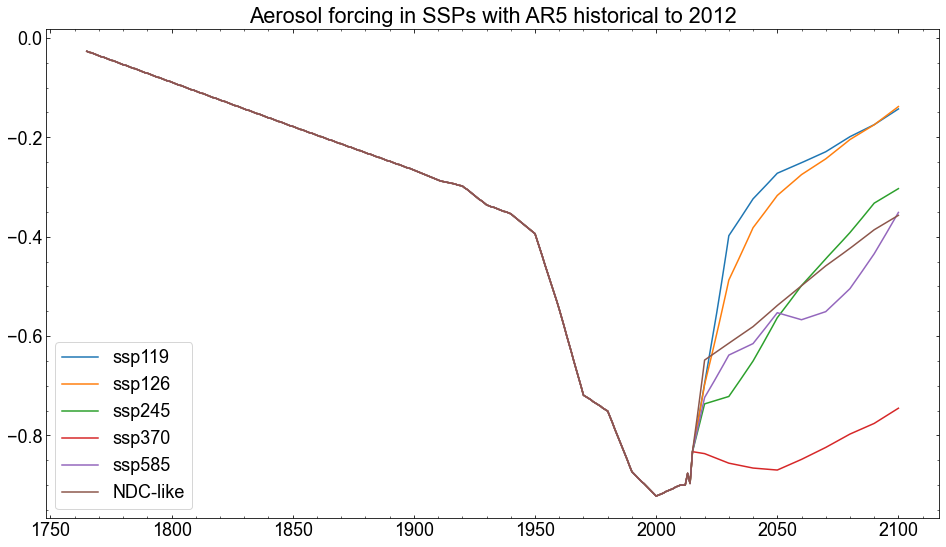

In [31]:
pl.plot(np.arange(1765,2101),ssp119_cmip5aer, label='ssp119')
pl.plot(np.arange(1765,2101),ssp126_cmip5aer, label='ssp126')
pl.plot(np.arange(1765,2101),ssp245_cmip5aer, label='ssp245')
pl.plot(np.arange(1765,2101),ssp370_cmip5aer, label='ssp370')
pl.plot(np.arange(1765,2101),ssp585_cmip5aer, label='ssp585')
pl.plot(np.arange(1765,2101),NDC_cmip5aer, label='NDC-like')
pl.legend()
pl.title('Aerosol forcing in SSPs with AR5 historical to 2012')

In [32]:
# fractional uncertainties - based on the FAIR code
seed    = 36572 
zscore = st.norm.ppf(0.95)

unc_ranges = np.array([0.17,      # CO2
                   0.17,      # CH4: updated value from etminan 2016
                   0.10,      # N2O
                   0.20,      # other WMGHS
                   0.50,      # tropospheric O3
                   1.00,      # stratospheric O3
                   5./7.,     # stratospheric WV from CH4
                   0.00,      # contrails (lognormal)
                   0.8/0.9,   # aerosols - OLD!
                   0.00,      # black carbon on snow (lognormal)
                   2./3.,     # land use change
                   3.5/18.5,  # volcanic
                   1.00])/(zscore) # (linear offset trend)

scale_cmip5aer = st.norm.rvs(size=(samples,13), loc=np.ones((samples,13)), scale=np.ones((samples, 13)) * unc_ranges[None,:], random_state=seed)
scale_cmip5aer[:,9] = st.lognorm.rvs(0.5, size=samples, random_state=seed+1)
#scale[:,7]  = st.lognorm.rvs(0.65, size=samples, random_state=seed+2)

# truncated normal distribution for contrails
scale_cmip5aer[:,7] = st.truncnorm.rvs(-1.68, 5, loc=1, scale=1/st.norm.ppf(0.95), size=samples, random_state=seed+2)

# aerosols
scale_cmip5aer[scale_cmip5aer[:,8]>1,8] = 1.0/0.8*(scale_cmip5aer[scale_cmip5aer[:,8]>1,8]-1) + 1

# solar
scale_cmip5aer[:,12] = scale_cmip5aer[:,12] - 1.0
scale_cmip5aer[scale_cmip5aer[:,12]>0,12] = 2*(scale_cmip5aer[scale_cmip5aer[:,12]>0,12])

# rapid adjustments for CO2 and CH4
scale_cmip5aer[:,0] = scale_cmip5aer[:,0] * 1.05
scale_cmip5aer[:,1] = scale_cmip5aer[:,1] * 0.86
np.percentile(scale_cmip5aer[:,8], [5,50,95])*(-0.9)

array([-0.15979051, -0.86998164, -1.85229735])

In [33]:
nt = 336
Tssp119_cmip5aer = np.zeros((336, samples))
Tssp126_cmip5aer = np.zeros((336, samples))
Tssp245_cmip5aer = np.zeros((336, samples))
Tssp370_cmip5aer = np.zeros((336, samples))
Tssp585_cmip5aer = np.zeros((336, samples))
Tndc_cmip5aer    = np.zeros((336, samples))
Fssp119_cmip5aer = np.zeros((336, samples))
Fssp126_cmip5aer = np.zeros((336, samples))
Fssp245_cmip5aer = np.zeros((336, samples))
Fssp370_cmip5aer = np.zeros((336, samples))
Fssp585_cmip5aer = np.zeros((336, samples))
Fndc_cmip5aer    = np.zeros((336, samples))

for i in range(samples):
    _,F,Tssp119_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ssp119[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=ssp119_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp119_cmip5aer[:,i] = Tssp119_cmip5aer[:,i] - np.mean(Tssp119_cmip5aer[85:136,i])
    Fssp119_cmip5aer[:,i] = np.sum(F, axis=1)
   
    _,F,Tssp126_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ssp126[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=ssp126_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp126_cmip5aer[:,i] = Tssp126_cmip5aer[:,i] - np.mean(Tssp126_cmip5aer[85:136,i])
    Fssp126_cmip5aer[:,i] = np.sum(F, axis=1)
    
    _,F,Tssp245_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ssp245[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=ssp245_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp245_cmip5aer[:,i] = Tssp245_cmip5aer[:,i] - np.mean(Tssp245_cmip5aer[85:136,i])
    Fssp245_cmip5aer[:,i] = np.sum(F, axis=1)
    
    _,F,Tssp370_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ssp370[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=ssp370_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp370_cmip5aer[:,i] = Tssp370_cmip5aer[:,i] - np.mean(Tssp370_cmip5aer[85:136,i])
    Fssp370_cmip5aer[:,i] = np.sum(F, axis=1)
    
    _,F,Tssp585_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ssp585[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=ssp585_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp585_cmip5aer[:,i] = Tssp585_cmip5aer[:,i] - np.mean(Tssp585_cmip5aer[85:136,i])
    Fssp585_cmip5aer[:,i] = np.sum(F, axis=1)
    
    _,F,Tndc_cmip5aer[:,i] = fair_scm(
        emissions=emissions_ndc[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale_cmip5aer[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        aerosol_forcing='external',
        F_aerosol=NDC_cmip5aer,
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tndc_cmip5aer[:,i] = Tndc_cmip5aer[:,i] - np.mean(Tndc_cmip5aer[85:136,i])
    Fndc_cmip5aer[:,i] = np.sum(F, axis=1)

/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


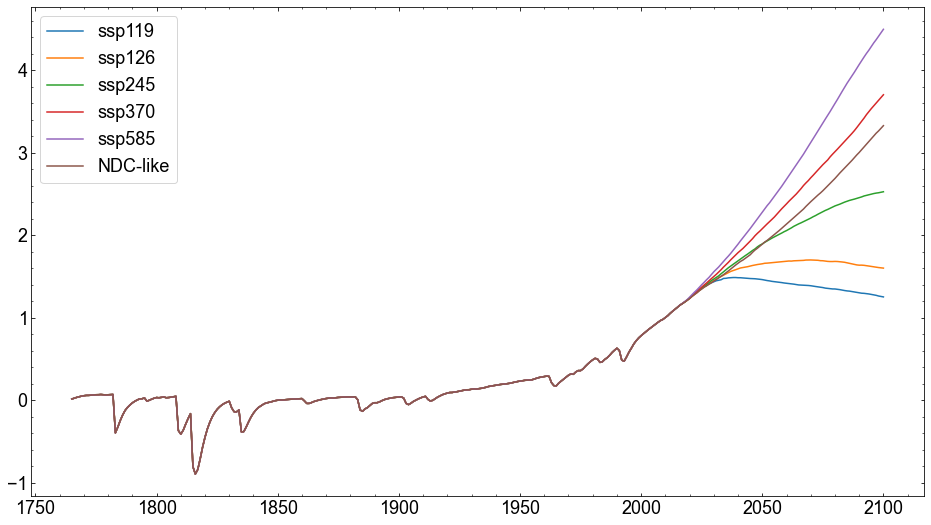

In [34]:
pl.plot(np.arange(1765,2101),np.median(Tssp119_cmip5aer,axis=1), label='ssp119');
pl.plot(np.arange(1765,2101),np.median(Tssp126_cmip5aer,axis=1), label='ssp126');
pl.plot(np.arange(1765,2101),np.median(Tssp245_cmip5aer,axis=1), label='ssp245');
pl.plot(np.arange(1765,2101),np.median(Tssp370_cmip5aer,axis=1), label='ssp370');
pl.plot(np.arange(1765,2101),np.median(Tssp585_cmip5aer,axis=1), label='ssp585');
pl.plot(np.arange(1765,2101),np.median(Tndc_cmip5aer,axis=1), label='NDC-like');
pl.legend()

In [35]:
emissions_columns = [
    'Year',
    'CO2 FF+I (GtC)',
    'CO2 AFOLU (GtC)',
    'CH4 (MtCH4)',
    'N2O (MtN2)',
    'SO2 (MtS)',
    'CO (MtCO)',
    'NMVOC (MtNMVOC)',
    'NOx (MtN)',
    'BC (MtC)',
    'OC (MtC)',
    'NH3 (MtNH3)',
    'CF4',
    'C2F6',
    'C6F14',
    'HFC23',
    'HFC32',
    'HFC43_10',
    'HFC125',
    'HFC134a',
    'HFC143a',
    'HFC227ea',
    'HFC245fa',
    'SF6',
    'CFC_11',
    'CFC_12',
    'CFC_113',
    'CFC_114',
    'CFC_115',
    'CARB_TET',
    'MCF',
    'HCFC_22',
    'HCFC_141B',
    'HCFC_142B',
    'HALON1211',
    'HALON1202',
    'HALON1301',
    'HALON2402',
    'CH3BR',
    'CH3CL'
]

df = pd.DataFrame(data=emissions_ssp119[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_emissions_revision1.csv')

df = pd.DataFrame(data=emissions_ssp126[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_emissions_revision1.csv')

df = pd.DataFrame(data=emissions_ssp245[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_emissions_revision1.csv')

df = pd.DataFrame(data=emissions_ssp370[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_emissions_revision1.csv')

df = pd.DataFrame(data=emissions_ssp585[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_emissions_revision1.csv')

df = pd.DataFrame(data=emissions_ndc[:nt,:], columns=emissions_columns)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ndc_emissions_revision1.csv')

In [36]:
df = pd.DataFrame(data=Tndc_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Tssp119_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Tssp126_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Tssp245_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Tssp370_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Tssp585_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_temps_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fndc_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fssp119_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fssp126_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fssp245_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fssp370_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=Fssp585_cmip5aer)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_forc_AR5aero_revision1.csv')

df = pd.DataFrame(data=(NDC_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_forcaer_AR5aero_revision1.csv')

df = pd.DataFrame(data=(ssp119_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_forcaer_AR5aero_revision1.csv')

df = pd.DataFrame(data=(ssp126_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_forcaer_AR5aero_revision1.csv')

df = pd.DataFrame(data=(ssp245_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_forcaer_AR5aero_revision1.csv')

df = pd.DataFrame(data=(ssp370_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_forcaer_AR5aero_revision1.csv')

df = pd.DataFrame(data=(ssp585_cmip5aer[None,:] * scale_cmip5aer[:,8:9]).T)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_forcaer_AR5aero_revision1.csv')

In [37]:
nt = 336
Tssp370_lowNTCF = np.zeros((336, samples))
for i in range(samples):
    _,_,Tssp370_lowNTCF[:,i] = fair_scm(
        emissions=emissions_ssp370_lowNTCF[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp370_lowNTCF[:,i] = Tssp370_lowNTCF[:,i] - np.mean(Tssp370_lowNTCF[85:136,i])

/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))
/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in multiply
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [38]:
nt = 336
Tssp434 = np.zeros((336, samples))
for i in range(samples):
    _,_,Tssp434[:,i] = fair_scm(
        emissions=emissions_ssp434[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp434[:,i] = Tssp434[:,i] - np.mean(Tssp434[85:136,i])

In [39]:
nt = 336
Tssp460 = np.zeros((336, samples))
for i in range(samples):
    _,_,Tssp460[:,i] = fair_scm(
        emissions=emissions_ssp460[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp460[:,i] = Tssp460[:,i] - np.mean(Tssp460[85:136,i])

In [40]:
nt = 336
Tssp534_over = np.zeros((336, samples))
for i in range(samples):
    _,_,Tssp534_over[:,i] = fair_scm(
        emissions=emissions_ssp534_over[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Tssp534_over[:,i] = Tssp534_over[:,i] - np.mean(Tssp534_over[85:136,i])

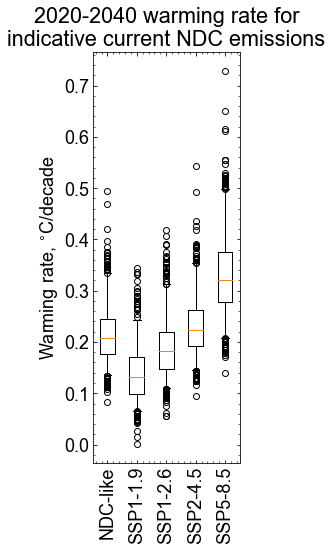

In [41]:
fig, ax = pl.subplots(figsize=(4,8))
ax.boxplot([(Tndc[275]- Tndc[255])/2, 
            (Tssp119[275]-Tssp119[255])/2,
            (Tssp126[275]-Tssp126[255])/2,
            (Tssp245[275]-Tssp245[255])/2,
            (Tssp585[275]-Tssp585[255])/2], whis=(5,95));
#ax.boxplot((Tssp245[275]-Tssp245[255])/2, whis=(5,95))
ax.set_xticklabels(['NDC-like', 'SSP1-1.9','SSP1-2.6', 'SSP2-4.5','SSP5-8.5'], rotation=90)
ax.set_ylabel('Warming rate, $^{\circ}$C/decade')
ax.set_title('2020-2040 warming rate for\nindicative current NDC emissions')
pl.tight_layout()

In [42]:
df = pd.DataFrame(data=Tndc)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/NDC_temps_revision1.csv')

df = pd.DataFrame(data=Tssp119)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp119_temps_revision1.csv')

df = pd.DataFrame(data=Tssp126)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp126_temps_revision1.csv')

df = pd.DataFrame(data=Tssp245)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp245_temps_revision1.csv')

df = pd.DataFrame(data=Tssp370)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp370_temps_revision1.csv')

df = pd.DataFrame(data=Tssp585)
df['Year'] = np.arange(1765,2101)
df.set_index('Year', inplace=True)
df.to_csv('data_out/ssp585_temps_revision1.csv')

In [43]:
nt = 336
_,_,Tssp126_median = fair_scm(
    emissions=emissions_ssp126[:nt,:],
    tcrecs=np.array((np.median(tcr), np.median(ecs))),
    F2x=4.01,
    rc=0.03,
    scaleAerosolAR5=False,
    scaleHistoricalAR5=False,
    scale_F2x=False,
    scale=np.array([1.05,0.86,1,1,1,1,1,1,0.62,1,1,1,1]),
    F_volcanic=vol[:nt],
    F_solar=sol[:nt],#+scale[i,12],
    natural=nat[:nt,:],
)
Tssp126_median = Tssp126_median - np.mean(Tssp126_median[85:136])

In [44]:
Trcp85 = np.zeros((336, samples))
for i in range(samples):
    _,_,Trcp85[:,i] = fair_scm(
        emissions=rcp85.Emissions.emissions[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#+scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Trcp85[:,i] = Trcp85[:,i] - np.mean(Trcp85[85:136,i])

/nfs/see-fs-02_users/mencsm/FAIR/fair/gas_cycle/fair1.py:66: RuntimeWarning: overflow encountered in exp
  iirf_arr = alp_b*(np.sum(a*tau*(1.0 - np.exp(-iirf_h/(tau*alp_b)))))


In [45]:
Trcp26 = np.zeros((336, samples))
for i in range(samples):
    _,_,Trcp26[:,i] = fair_scm(
        emissions=rcp26.Emissions.emissions[:nt,:],
        tcrecs=tcrecs[i],
        F2x=4.01,
        scaleAerosolAR5=False,
        scaleHistoricalAR5=False,
        scale_F2x=False,
        scale=scale[i,:],
        F_volcanic=vol[:nt],
        F_solar=sol[:nt],#scale[i,12],
        natural=nat[:nt,:],
        r0 = r0[i],
        rc = rc[i],
        rt = rt[i]
    )
    Trcp26[:,i] = Trcp26[:,i] - np.mean(Trcp26[85:136,i])

In [46]:
endyear=2101
ncout = Dataset('data_out/cmip6_highecs_revision1.nc', 'w')
timdim = ncout.createDimension('time', None)
rundim = ncout.createDimension('run',samples)
timvar = ncout.createVariable('time','i4',('time',))
runvar = ncout.createVariable('run','i4',('run',))

ssp119var  = ncout.createVariable('ssp119','f4',('time','run'))
ssp126var  = ncout.createVariable('ssp126','f4',('time','run'))
ssp245var  = ncout.createVariable('ssp245','f4',('time','run'))
ssp370var  = ncout.createVariable('ssp370','f4',('time','run'))
ssp370lvar  = ncout.createVariable('ssp370_lowNTCF','f4',('time','run'))
ssp434var  = ncout.createVariable('ssp434','f4',('time','run'))
ssp460var  = ncout.createVariable('ssp460','f4',('time','run'))
ssp534ovar  = ncout.createVariable('ssp534_over','f4',('time','run'))
ssp585var  = ncout.createVariable('ssp585','f4',('time','run'))
rcp26var  = ncout.createVariable('rcp26','f4',('time','run'))
rcp85var  = ncout.createVariable('rcp85','f4',('time','run'))
timvar[:] = np.arange(1765,endyear)
runvar[:] = np.arange(samples)
ssp119var[:] = Tssp119
ssp126var[:] = Tssp126
ssp245var[:] = Tssp245
ssp370var[:] = Tssp370
ssp370lvar[:] = Tssp370_lowNTCF
ssp434var[:] = Tssp434
ssp460var[:] = Tssp460
ssp534ovar[:] = Tssp534_over
ssp585var[:] = Tssp585
rcp26var[:] = Trcp26
rcp85var[:] = Trcp85
ncout.close()